# Convolutionalization

In this notebook, we explain the idea of convolutionalization, working with mnist digits.

Convolutionalization is the process of transforming a neural network containing dense layers (typically some classification network) into a fully convolutional one.

The fully convolutional network can be used as a detector kernel, convolving it over an input image to produce a "heat map" of the locations where objects are found.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalMaxPool2D, MaxPool2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Here we load the mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000,28,28,1)/255.
x_test = x_test.reshape(10000,28,28,1)/255.
print(x_train.shape)
print(x_train.min())
print(x_train.max())

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
0.0
1.0


It is convenient to add to the detector a "background" class, containing no object. For traning and testing we create a bunch of images "almost black" (to be refined as an exercise).

In [3]:
background = np.random.randint(0,5,(6000,28,28,1))/255.
background_test = np.random.randint(0,5,(1000,28,28,1))/255.

Let us see an example of background, together with a typical image.

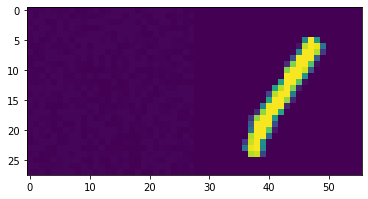

In [4]:
imageplot = plt.imshow(np.reshape(np.concatenate((background[15],x_train[23]),axis=1),(28,56)))
plt.show()

We extend the training set. Backgound gets label "10".

In [10]:
x_train_bg = np.concatenate((x_train,background))
x_test_bg = np.concatenate((x_test,background_test))
y_train_bg = np.concatenate((y_train,np.ones(6000)*10))
y_test_bg = np.concatenate((y_test,np.ones(1000)*10))

In [11]:
print(x_train_bg.shape)

(66000, 28, 28, 1)


The classifier is composed by an initial part made by 2Dconvolutional layers, followed by two dense layers (intermixed by dropout).

Every other convolution has stride 2, halving the size of the input. At the same time we double the channel dimension, to partially compensate the dimensionality loss.


In [12]:
iimg = Input(shape=(28,28,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = GlobalMaxPool2D()(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) #we have now 11 categories

model = Model(inputs=[iimg],outputs=[cout])

Here is the model summary. 

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                             

We compile the model with (sparse) categorical crossentropy. 
Recall that the training set is automatically shuffled by the fit method.

We add accuracy as additional metric to evaluate the model.

In [14]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Ten epochs of training should be enough.

In [15]:
model.fit(x_train_bg,y_train_bg,
          epochs=10,
          batch_size=100,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/10
660/660 [==============================] - 16s 7ms/step - loss: 0.4351 - accuracy: 0.8655 - val_loss: 0.1524 - val_accuracy: 0.9552
Epoch 2/10
660/660 [==============================] - 4s 7ms/step - loss: 0.1186 - accuracy: 0.9638 - val_loss: 0.0968 - val_accuracy: 0.9697
Epoch 3/10
660/660 [==============================] - 4s 7ms/step - loss: 0.0798 - accuracy: 0.9759 - val_loss: 0.0745 - val_accuracy: 0.9770
Epoch 4/10
660/660 [==============================] - 5s 7ms/step - loss: 0.0621 - accuracy: 0.9802 - val_loss: 0.0645 - val_accuracy: 0.9793
Epoch 5/10
660/660 [==============================] - 4s 7ms/step - loss: 0.0508 - accuracy: 0.9844 - val_loss: 0.0541 - val_accuracy: 0.9827
Epoch 6/10
660/660 [==============================] - 4s 7ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.0527 - val_accuracy: 0.9827
Epoch 7/10
660/660 [==============================] - 4s 7ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 0.0496 - val_accuracy: 0.9843
Epoch

Let us save the weights, since we need them.

In [16]:
model.save_weights("mymodel.hdf5")

Now we define a fully convolutional network. We aim to obtain in output a feature map, that is a 2D image.

A simple way to do it is to directly apply the Dense layers to the 3D features maps before maxpooling. In tensorflow, this is equivalent to apply a unary convolution, that is the dense layer only operates on channels.

In [17]:
iimg = Input(shape=(None,None,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish',name="l1")(iimg)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish',name="l2")(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish',name="l3")(x)
#x = MaxPool2D((3,3),padding='same',strides=1)(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) 

model_c = Model(inputs=[iimg],outputs=[cout])

Let us see the summary. 

Observe that the spatial dimension of the input is unspecified and that we get a spatial heat map as output. 

To beeter understand the relation between the input-output spatial dimensions fix the some shapes for inputs and recompute the summary.

In [18]:
model_c.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 l1 (Conv2D)                 (None, None, None, 16)    160       
                                                                 
 l2 (Conv2D)                 (None, None, None, 32)    4640      
                                                                 
 l3 (Conv2D)                 (None, None, None, 64)    18496     
                                                                 
 dense_4 (Dense)             (None, None, None, 64)    4160      
                                                                 
 dense_5 (Dense)             (None, None, None, 11)    715       
                                                                 
Total params: 28,171
Trainable params: 28,171
Non-trainable

The previous fully convolutional network has precisely the same parameters of the previous classifier, so we can just load the saved weights.



In [19]:
model_c.load_weights("mymodel.hdf5")

Let us create an image composed by several mnist digits.

In [20]:
rimg = np.zeros((128,128,1))
rimg[12:40,6:34] = x_test[15]
rimg[40:68,30:58] = x_test[14]
rimg[15:43,45:73] = x_test[13]
rimg[5:33,75:103] = x_test[12]
rimg[45:73,90:118] = x_test[11]
rimg[89:117,70:98] = x_test[9]
rimg[80:108,25:53] = x_test[6]

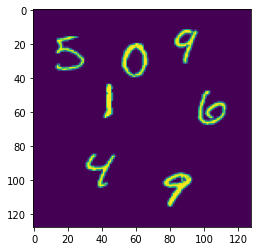

In [21]:
imageplot = plt.imshow(np.reshape(rimg,(128,128)))
plt.show()

We use the cmap function of pyplot to map classes to colors.

In [23]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(12)

def cmap1(n):
  return cmap(n)[0:3]

print(cmap1(3),cmap1(10))

(0.38920293465748, 1.0, 0.0) (1.0, 0.0, 0.6306823551141734)


Now we try to use the fully convolutional network to "locate" digits in out sample image.

In [25]:
fmap = model_c.predict(np.expand_dims(rimg,axis=0))[0]
print(fmap.shape)

(16, 16, 11)


In [26]:
fmap = np.argmax(fmap,axis=-1)
print(fmap.shape)
print(fmap)

(16, 16)
[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10  8  3 10 10 10 10]
 [10  5  5 10 10 10  6  1 10 10  4  1 10 10 10 10]
 [10  3  3  3 10  7  1  4  1 10 10 10 10 10 10 10]
 [10 10 10 10 10 10  4  3 10 10 10 10 10 10 10 10]
 [10 10 10 10  4  1 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  7  1 10 10 10 10 10  6  3  7 10 10]
 [10 10 10 10 10  7 10 10 10 10 10  8  8  3 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  6  4 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  5  7  1 10 10 10 10  6 10 10 10 10 10]
 [10 10 10 10  2 10 10 10 10  9  3  1 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  7  7 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]


The result is better appreciated as a heatmap.

In [ ]:
vcmap = np.vectorize(cmap1)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

(16, 16, 3)


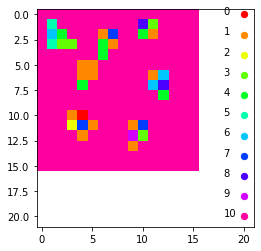

In [ ]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

Location is good but classification is not always accurate.

#Improvements

Let us try to improve things by training a classifier more robust to dispacements (mnist data are precisely centered, while the stride of the convolutional network is 8).

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        #rotation_range=0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #shear_range=0.15,
        #zoom_range=0.15,
        horizontal_flip=False,
        fill_mode='nearest')

Let's look at sample samples of augmement data:

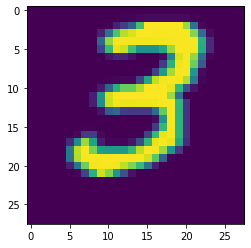

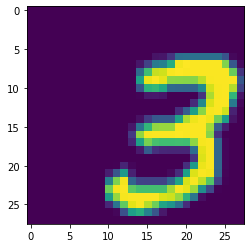

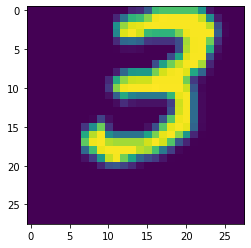

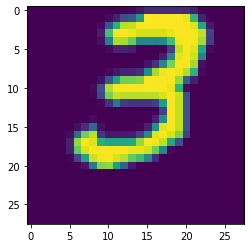

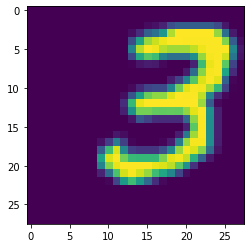

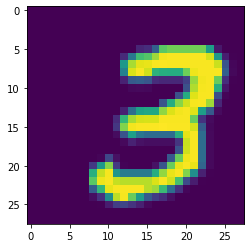

In [28]:
i = 0
for batch in datagen.flow(x_train[7:8], batch_size=1):
    i += 1
    plt.imshow(batch[0,:,:,0])
    plt.show()
    if i > 5:
        break  # otherwise the generator would loop indefinitely

In [29]:
train_generator = datagen.flow(x_train_bg,y_train_bg,batch_size=100)

In [30]:
model.fit(train_generator,
          steps_per_epoch = 600,
          epochs=5,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
600/600 [==============================] - 21s 34ms/step - loss: 0.2239 - accuracy: 0.9314 - val_loss: 0.0978 - val_accuracy: 0.9684
Epoch 2/5
600/600 [==============================] - 22s 36ms/step - loss: 0.1121 - accuracy: 0.9647 - val_loss: 0.0778 - val_accuracy: 0.9760
Epoch 3/5
600/600 [==============================] - 21s 34ms/step - loss: 0.0929 - accuracy: 0.9710 - val_loss: 0.0847 - val_accuracy: 0.9721
Epoch 4/5
600/600 [==============================] - 26s 43ms/step - loss: 0.0827 - accuracy: 0.9747 - val_loss: 0.0752 - val_accuracy: 0.9755
Epoch 5/5
600/600 [==============================] - 21s 36ms/step - loss: 0.0782 - accuracy: 0.9758 - val_loss: 0.0885 - val_accuracy: 0.9718


In [ ]:
model.save_weights("mymodel_bis.hdf5")

In [ ]:
model_c.load_weights("mymodel_bis.hdf5")

In [ ]:
fmap = model_c.predict(np.expand_dims(rimg,axis=0))[0]
fmap = np.argmax(fmap,axis=-1)
print(fmap)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10  5 10 10 10 10 10 10 10  9  1 10 10 10 10]
 [10  2  8 10 10 10  6  7 10 10  4  1 10 10 10 10]
 [10  5  3 10 10  1  1  7 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10  6  3 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  1 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  1  1 10 10 10 10 10  1  4  9 10 10]
 [10 10 10 10 10 10 10 10 10 10 10  6  6  3 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10  4 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  1  4 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  4 10 10 10 10 10  9 10 10 10 10 10]
 [10 10 10 10  1 10 10 10 10  9  3 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
(16, 16, 3)


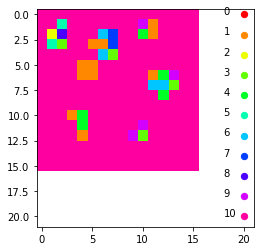

In [ ]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

As a second attemp we consider a sligtly more sophisticated classifier.

In [31]:
iimg = Input(shape=(28,28,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(16,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=1,padding='same',activation='swish')(x)
x = GlobalMaxPool2D()(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) #we have now 11 categories

model2 = Model(inputs=[iimg],outputs=[cout])

In [ ]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model2.fit(train_generator,
          steps_per_epoch = 600,
          epochs=5,
          validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
600/600 [==============================] - 24s 38ms/step - loss: 0.5457 - accuracy: 0.8158 - val_loss: 0.1573 - val_accuracy: 0.9504
Epoch 2/5
600/600 [==============================] - 22s 37ms/step - loss: 0.1406 - accuracy: 0.9570 - val_loss: 0.1269 - val_accuracy: 0.9595
Epoch 3/5
600/600 [==============================] - 26s 44ms/step - loss: 0.0994 - accuracy: 0.9691 - val_loss: 0.0738 - val_accuracy: 0.9755
Epoch 4/5
600/600 [==============================] - 22s 36ms/step - loss: 0.0758 - accuracy: 0.9761 - val_loss: 0.0660 - val_accuracy: 0.9799
Epoch 5/5
600/600 [==============================] - 22s 36ms/step - loss: 0.0641 - accuracy: 0.9804 - val_loss: 0.0525 - val_accuracy: 0.9825


In [ ]:
model2.save_weights("mymodel2.hdf5")

Now we convolutionalize the previous calssifier. In this case, we also leave a pooling layer after the convolution. Since we do not want to further decrease the spatial dimension of the feature map, we apply it with stride 1 (the default stride for pooling layers is equal to the dimension of the kernel).

In [ ]:
iimg = Input(shape=(None,None,1))
x = Conv2D(16,(3,3),strides=2,padding='same', activation='swish')(iimg)
x = Conv2D(16,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(32,(3,3),strides=1,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=2,padding='same',activation='swish')(x)
x = Conv2D(64,(3,3),strides=1,padding='same',activation='swish')(x)
x = MaxPool2D((3,3),padding='same',strides=1)(x)
x = Dense(64,activation = 'swish')(x)
cout = Dense(11, activation = 'softmax')(x) 

model2_c = Model(inputs=[iimg],outputs=[cout])

In [ ]:
model2_c.load_weights("mymodel2.hdf5")

In [ ]:
fmap = model2_c.predict(np.expand_dims(rimg,axis=0))[0]
fmap = np.argmax(fmap,axis=-1)
print(fmap)
fcmap = np.array(vcmap(fmap))
fcmap = np.transpose(fcmap,(1,2,0))
print(fcmap.shape)

[[10 10 10 10 10 10 10 10 10 10  0  9 10 10 10 10]
 [ 5  5  5 10 10 10 10 10 10  9  9  9  9 10 10 10]
 [ 5  5  5  5 10  1  0  0  0  9  9  9  9 10 10 10]
 [ 5  5  5  5 10  0  0  0  0  9  9  9  8 10 10 10]
 [ 0  3  3  0  1  1  0  0  0 10 10 10 10 10 10 10]
 [10 10 10 10  1  1  1  2  2 10 10  6  6  6 10 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  6  6 10]
 [10 10 10 10  1  1 10 10 10 10 10  6  6  6  0 10]
 [10 10 10 10 10 10 10 10 10 10 10  2  0  2  0 10]
 [10 10 10 10  0 10 10 10 10 10 10  2  2  2 10 10]
 [10 10 10  4  4  4  4 10 10 10 10 10 10 10 10 10]
 [10 10 10  4  4  4  4 10  0  0  9  9 10 10 10 10]
 [10 10 10  4  4  4  8 10  7  9  9  9 10 10 10 10]
 [10 10 10 10 10 10 10 10  7  9  9  9 10 10 10 10]
 [10 10 10 10 10 10 10 10  7  9  8  8 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]
(16, 16, 3)


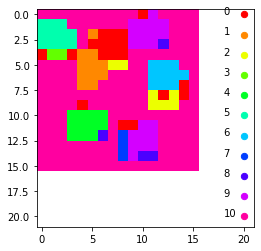

In [ ]:
fig,ax = plt.subplots()
ax.imshow(fcmap)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()